In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math

In [25]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

In [26]:
image_path = 'dog.tiff'
image_tensor = load_image(image_path)
image_tensor.size()

torch.Size([1, 3, 224, 224])

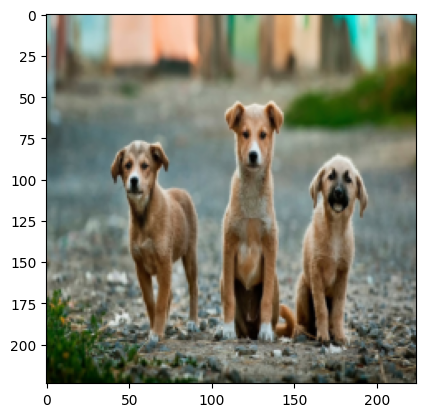

In [27]:
plt.imshow(image_tensor.squeeze(0).permute(1,2,0))

In [118]:
class GroupedConvTransposeNet(nn.Module):
    def __init__(self):
        super(GroupedConvTransposeNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=3, padding=1,),
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=24, out_channels=12, kernel_size=3, stride=3, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=12, out_channels=6, kernel_size=3, stride=3, padding=1,output_padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=6, out_channels=3, kernel_size=3, stride=3, padding=1,output_padding=2),
            nn.Sigmoid()  # Use sigmoid to match the input range [0, 1]
        )
    
    def forward(self, x):
        x = self.encoder(x)
        print(f"Shape after encoder: {x.shape}")
        x = self.decoder(x)
        print(f"Shape after decoder: {x.shape}")
        return x


In [119]:
model = GroupedConvTransposeNet()


In [120]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [121]:
num_epochs = 500
for epoch in range(num_epochs):
    
    # Forward
    model.train()
    output = model(image_tensor)

    loss = loss_fn(output, image_tensor)

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Shape after encoder: torch.Size([1, 24, 9, 9])
Shape after decoder: torch.Size([1, 3, 225, 225])


RuntimeError: The size of tensor a (225) must match the size of tensor b (224) at non-singleton dimension 3

In [ ]:
model.eval()
with torch.no_grad():
    reconstructed_image = model(image_tensor)

In [9]:
# Function to plot feature maps
def plot_feature_maps(feature_maps, layer_idx):
    num_filters = feature_maps.shape[0]
    cols = 8
    rows = math.ceil(num_filters / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()
    for i in range(num_filters):
        ax = axes[i]
        ax.imshow(feature_maps[i, :, :].numpy(), cmap='viridis')
        ax.set_title(f'Feature map {i+1}')
        ax.axis('off')
    plt.suptitle(f'Feature Maps After Layer {layer_idx}')
    plt.tight_layout()
    plt.show()


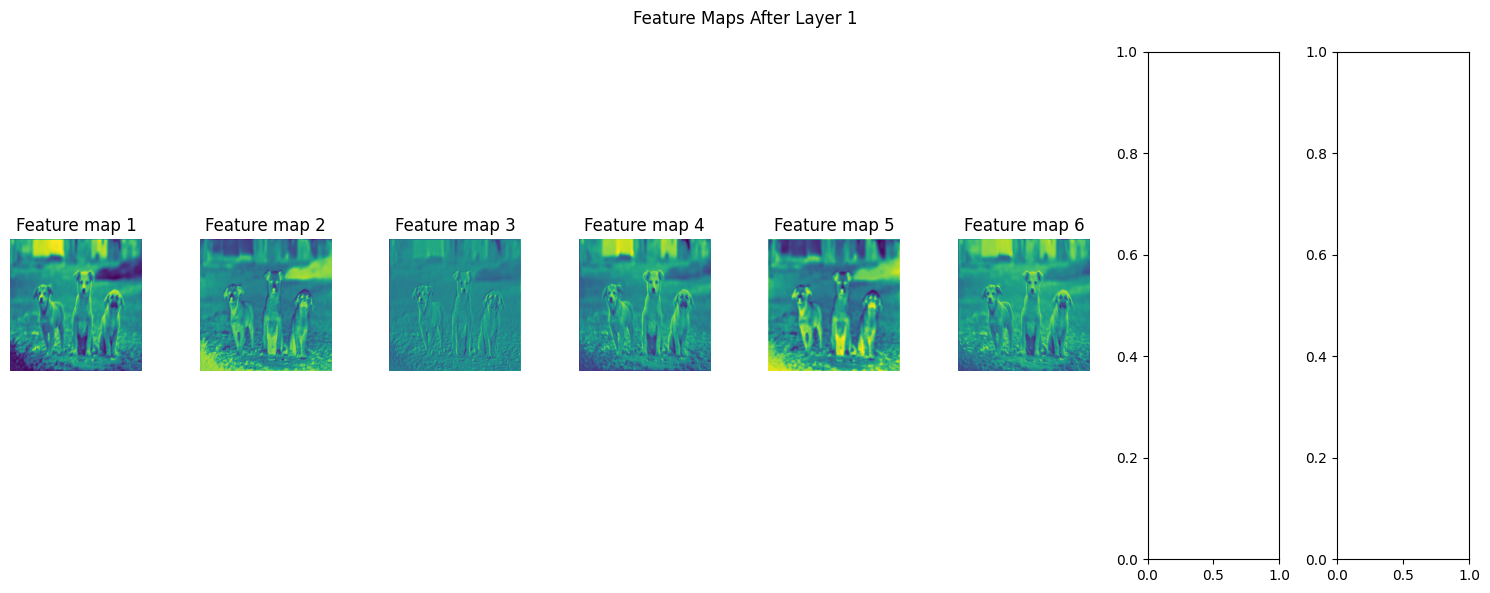

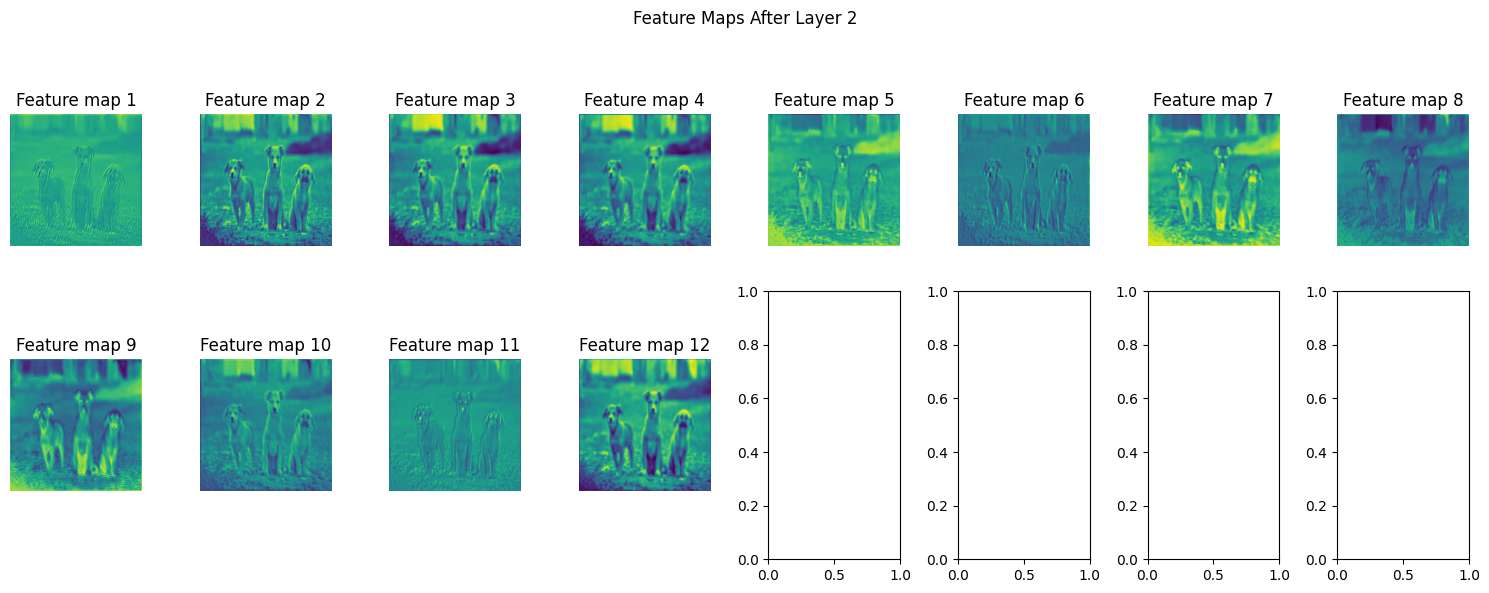

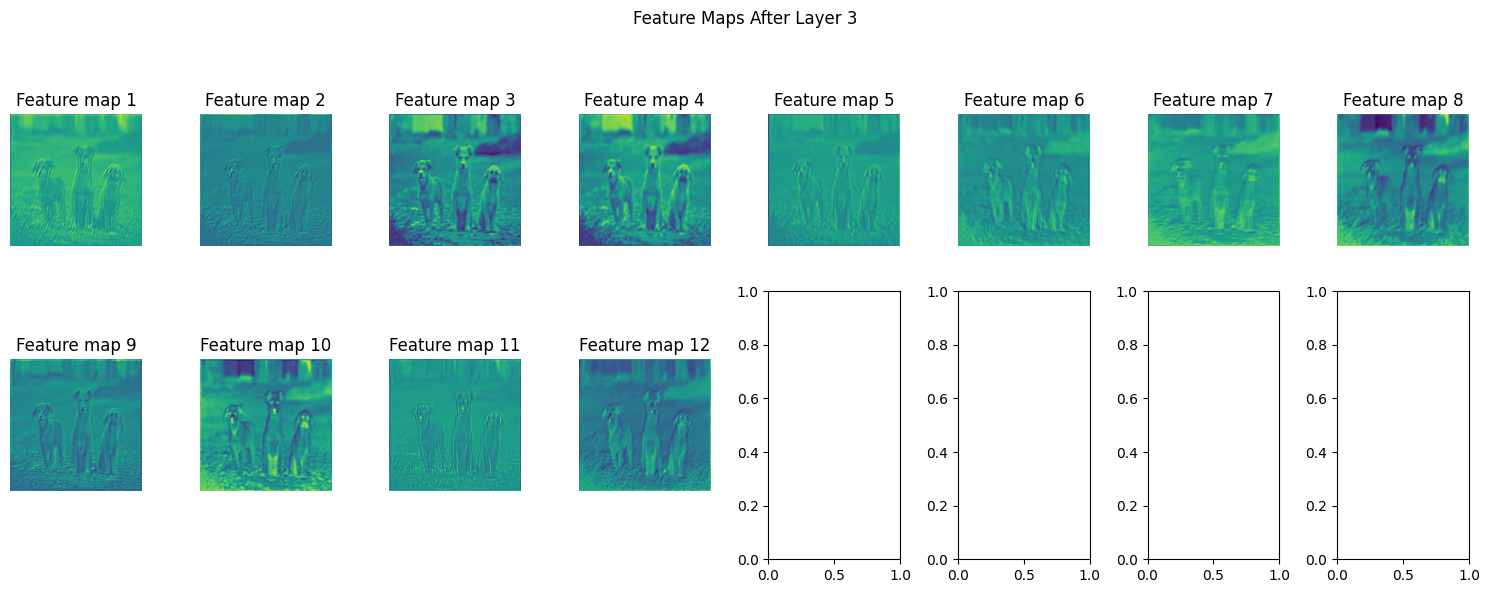

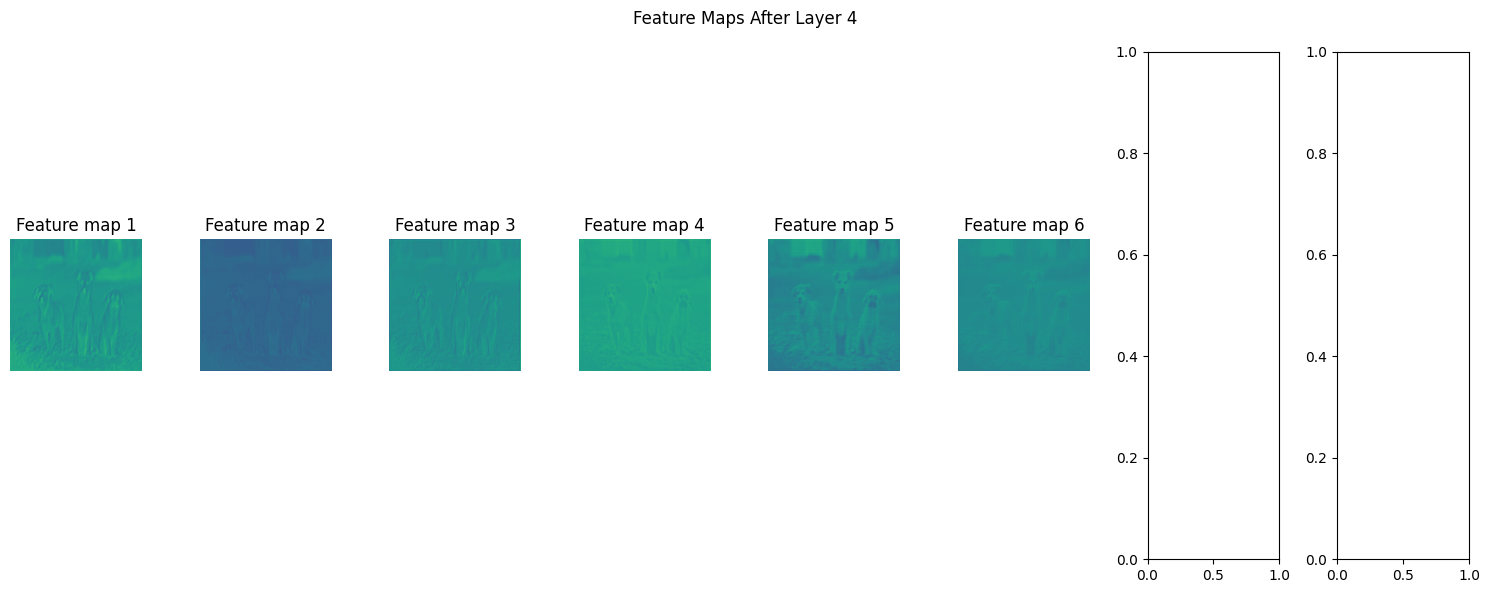

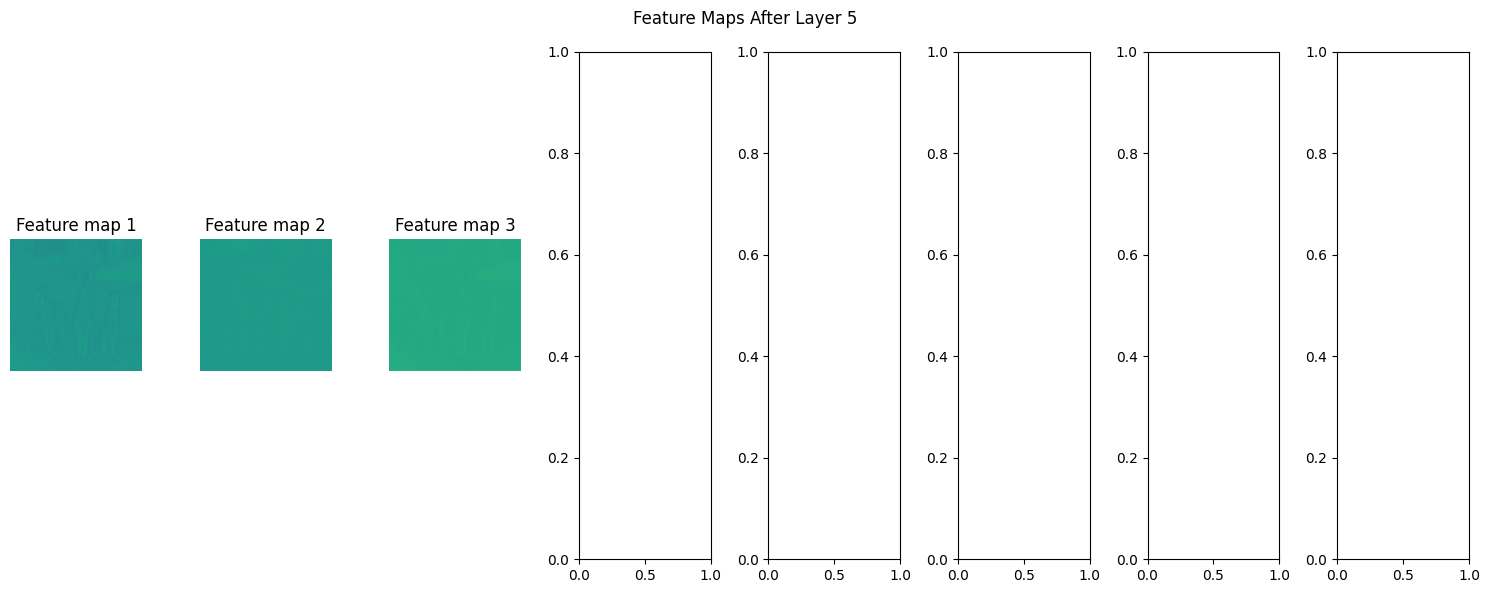

In [10]:
for idx ,fmap in enumerate(feature_maps):
    fmap = fmap.squeeze(0)
    plot_feature_maps(fmap, idx + 1)

Conclusion: As we increase the layer, feature maps will be more abstract and less directly recognizable.

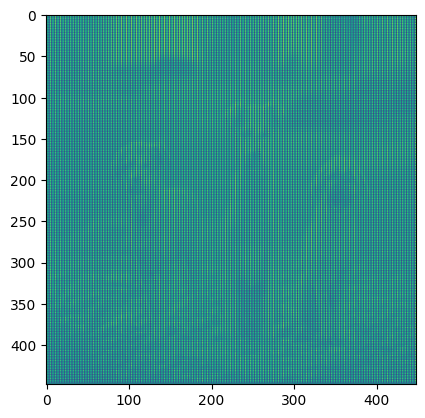

In [17]:
plt.imshow(feature_maps[3].squeeze(0)[5,:,:].numpy())
